# PUC Minas EAD - Trabalho de conclusão de curso

Trabalho de conclusão de curso de Guilherme Fernando Angélico para o título de especialista em Inteligência Artificial e Machine Learning. 28/02/2022

In [1]:
from platform import python_version
print('Versão da linguagem python utilizada para a execução desse notebook:', python_version())

Versão da linguagem python utilizada para a execução desse notebook: 3.9.7


## Detectando transações fraudulentas de cartão de crédito com Inteligência Artificial - Uma abordagem não supervisionada

!['Análise automatica de transações fraldulentas de cartão de crédito'](./images/analise-manual-de-risco.png)

## Definição do problema

Os sistemas comerciais sempre estão em constante evolução, e transacionar uma compra em um e-commerce é uma operação cada vez mais comum; E na mesma velocidade em que as transações ocorrem sempre há uma possibilidade de que essa transação seja fraudulenta, ou seja, não é o dententor do cartão efetuando a compra - uma pessoa maliciosa pode ter capturado esses dados e se passar por essa pessoa.

Nesse projeto, vamos criar um sistema capaz de analisar as transações financeiras e criar um modelo capaz de prever uma classe para cada transação indicando se ela é uma Transação  **Válida** ou um **Fraude**.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf
from pickle import dump, load
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from matplotlib import rcParams
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score ,precision_score, recall_score, accuracy_score, precision_recall_curve, classification_report

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [3]:
%reload_ext watermark
%watermark -a "Análise de fraudes em transações com cartões de crédito" --iversions

Author: Análise de fraudes em transações com cartões de crédito

matplotlib: 3.5.1
numpy     : 1.22.2
seaborn   : 0.11.2
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.4.1
tensorflow: 2.8.0



## Dataset

Para modelar nosso sistema de análise de transações fraudulentas vamos utilizar um dataset público disponível no Kaggle:

https://www.kaggle.com/mlg-ulb/creditcardfraud

O dataset possui um total de 31 colunas. Sendo 28 colunas com valores numérico/decimal, obtidos através do processo de PCA - afim de proteger as identidades e recursos confidencias, e outras 3 colunas, sendo: Número de segundos entre a primeira transação do dataset e a atual, O valor da transação e a Classe.

In [4]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraude"]

In [5]:
df = pd.read_csv('./data/creditcard.zip', sep=',', compression='zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Análise do dataset

Vamos analisar o dataset e identicar as caracteristicas das transações desse dataset

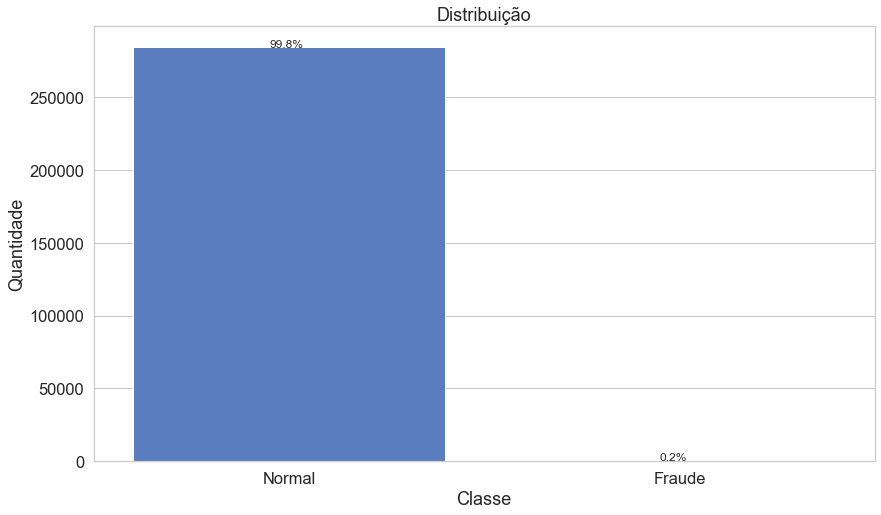

In [6]:
qtd_class = pd.value_counts(df['Class'], sort = True)
plt.title("Distribuição")
ax = sns.barplot(x=qtd_class.keys(), y=qtd_class.values)

for p in ax.patches:
    percent = '{:.1f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percent, (x, y), size=12)

ax.set_xticks(range(len(LABELS)), LABELS)
ax.set_xlabel("Classe")
ax.set_ylabel("Quantidade")
plt.show()

Vamos criar uma coluna de data/tempo para poder colocar nososs registros dentro de uma time series

In [7]:
data_base = dt.datetime(2013, 9, 1, 8, 0, 0)
data_base

datetime.datetime(2013, 9, 1, 8, 0)

In [8]:
df['Data'] = df['Time'].apply(lambda x: data_base + dt.timedelta(seconds=x))

In [9]:
df['Data']

0        2013-09-01 08:00:00
1        2013-09-01 08:00:00
2        2013-09-01 08:00:01
3        2013-09-01 08:00:01
4        2013-09-01 08:00:02
                 ...        
284802   2013-09-03 07:59:46
284803   2013-09-03 07:59:47
284804   2013-09-03 07:59:48
284805   2013-09-03 07:59:48
284806   2013-09-03 07:59:52
Name: Data, Length: 284807, dtype: datetime64[ns]

In [10]:
normal = df[df['Class'] == 0].copy()
fraude = df[df['Class'] == 1].copy()

In [11]:
print('Quantidade de registros normais: ', len(df[df['Class'] == 0]))
print('Quantidade de registros fraldados: ', len(df[df['Class'] == 1]))

Quantidade de registros normais:  284315
Quantidade de registros fraldados:  492


Vamos visualizar a distribuição dos dados

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


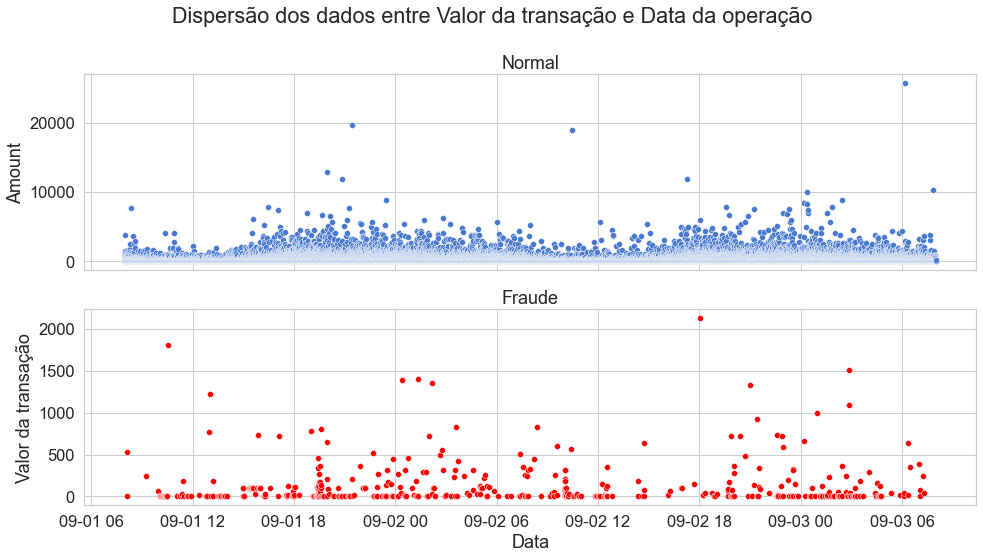

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
plt.suptitle('Dispersão dos dados entre Valor da transação e Data da operação')

ax1.set_title('Normal')
sns.scatterplot(data=normal, x='Data', y='Amount', ax=ax1)

ax2.set_title('Fraude')
sns.scatterplot(data=fraude, x='Data', y='Amount', ax=ax2, color='red')

plt.xlabel('Data')
plt.ylabel('Valor da transação')
plt.tight_layout()
plt.show()

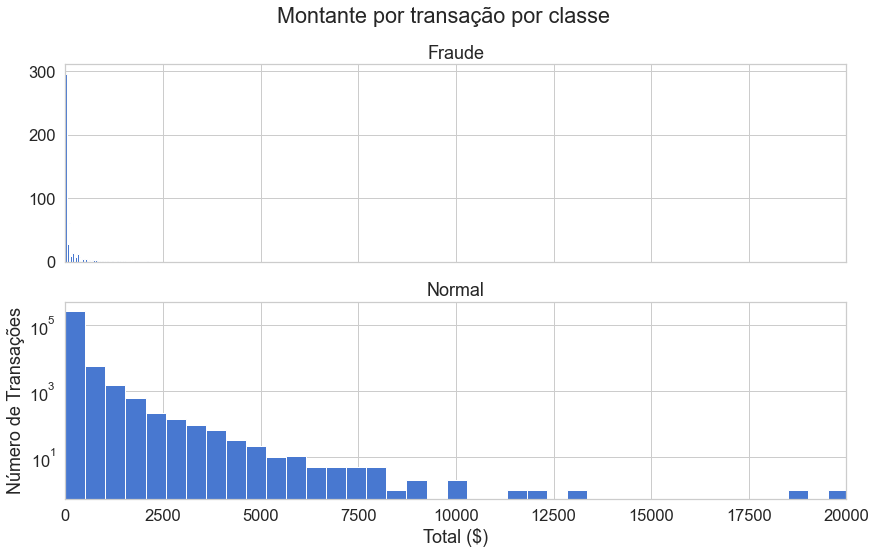

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Montante por transação por classe')

bins = 50

ax1.hist(fraude['Amount'], bins = bins)
ax1.set_title('Fraude')

ax2.hist(normal['Amount'], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Total ($)')
plt.ylabel('Número de Transações')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

<Figure size 1008x576 with 0 Axes>

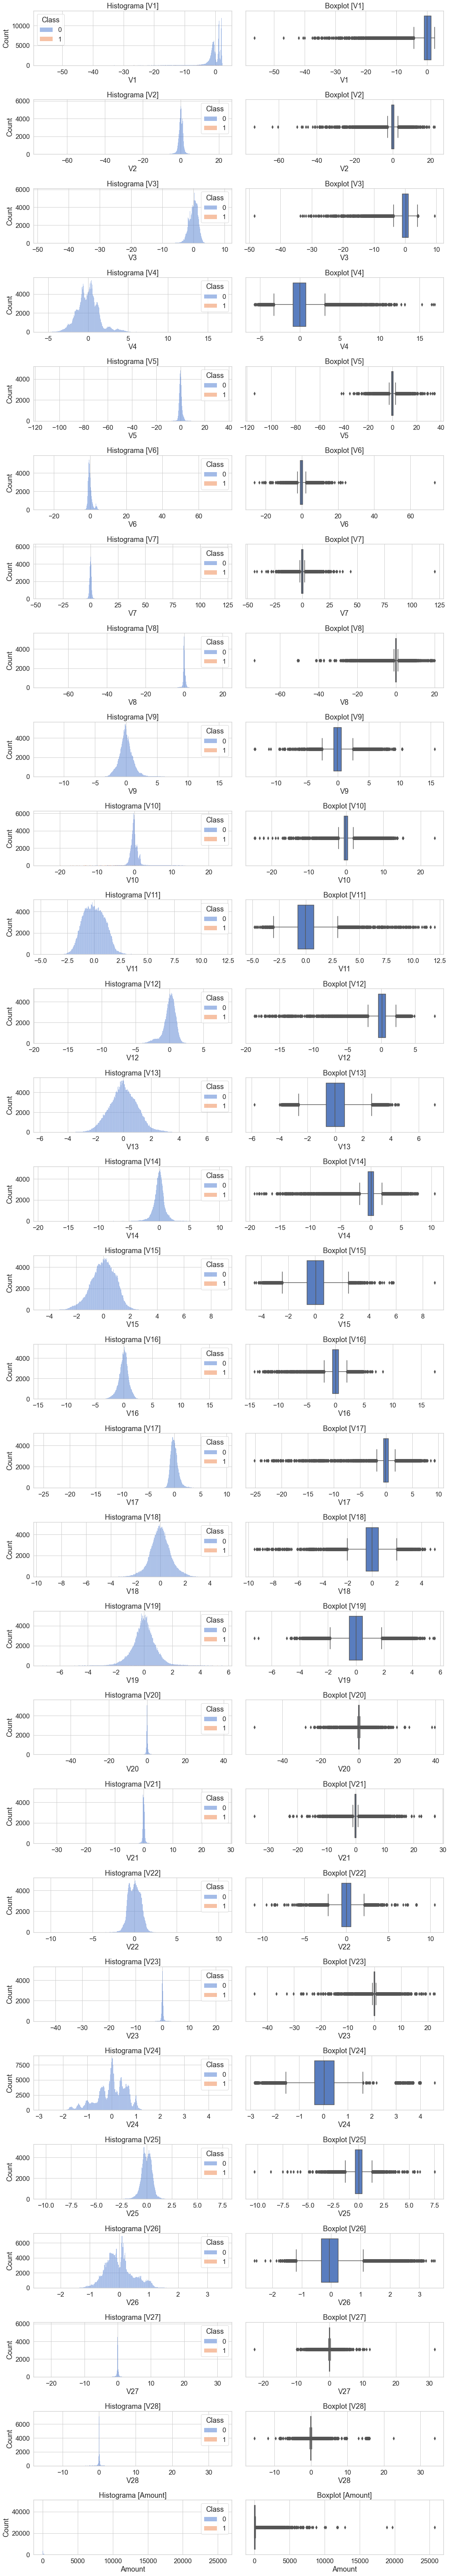

In [15]:
columns = df.columns[1:30]

plt.suptitle('Distribuição e Boxplot dos dados')
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(16,90))

for i, column in enumerate(columns):
    ax0 = axs[i, 0]
    ax0.set_title('Histograma [{}]'.format(column))
    sns.histplot(data=df, x=column, hue='Class', ax=ax0)
    
    ax1 = axs[i, 1]
    ax1.set_title('Boxplot [{}]'.format(column))
    sns.boxplot(data=df, x=column, hue='Class', ax=ax1, orient='h')

plt.tight_layout()
plt.show()

<Figure size 1008x576 with 0 Axes>

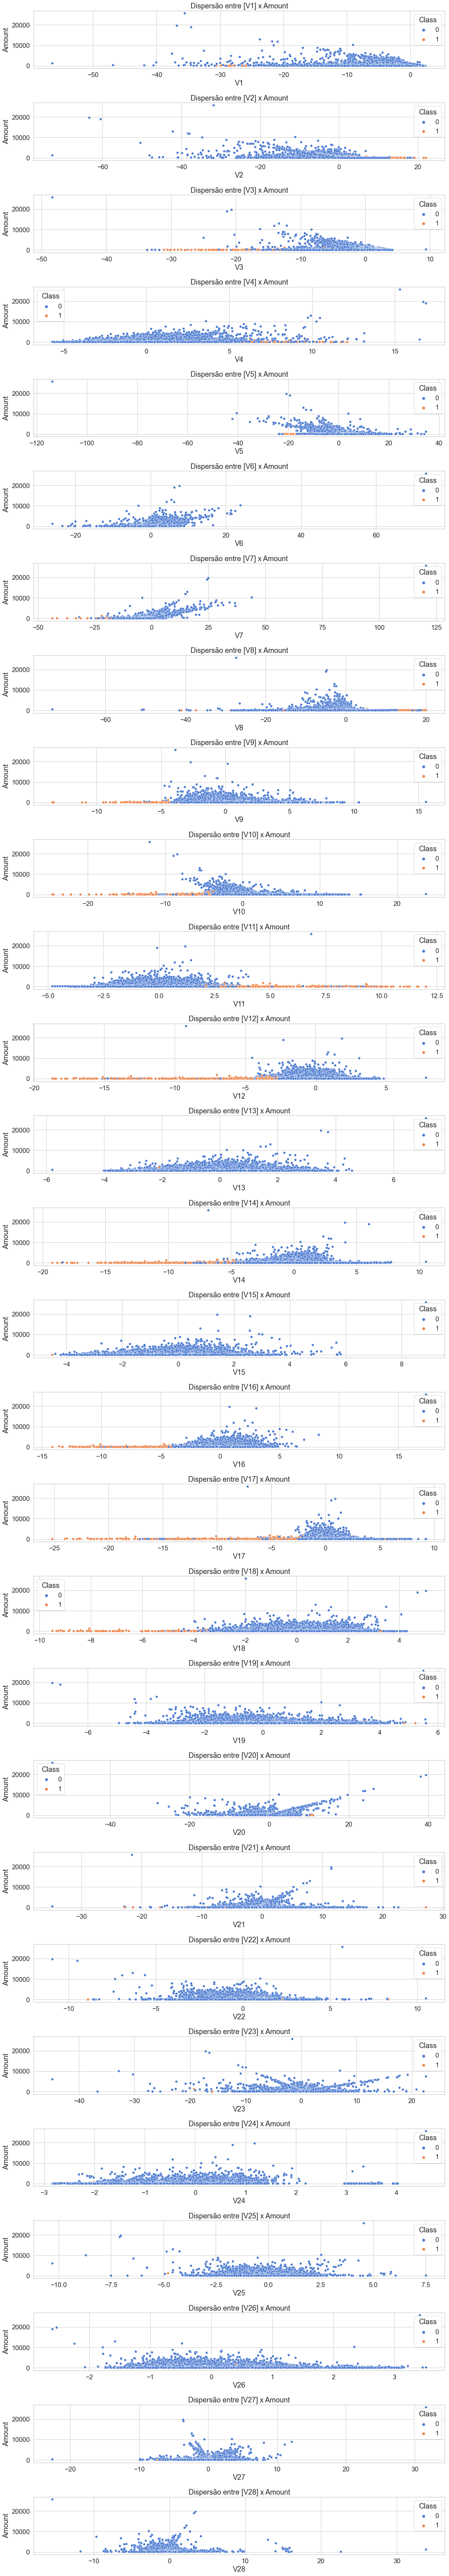

In [16]:
columns = df.columns[1:29]

plt.suptitle('Dispersão entre componentes principais e Amount')
fig, axs = plt.subplots(nrows=len(columns), ncols=1, figsize=(16,90))

for i, column in enumerate(columns):
    ax = axs[i]
    ax.set_title('Dispersão entre [{}] x Amount'.format(column))
    sns.scatterplot(data=df, x=column, y='Amount', hue='Class', ax=ax)

plt.tight_layout()
plt.show()

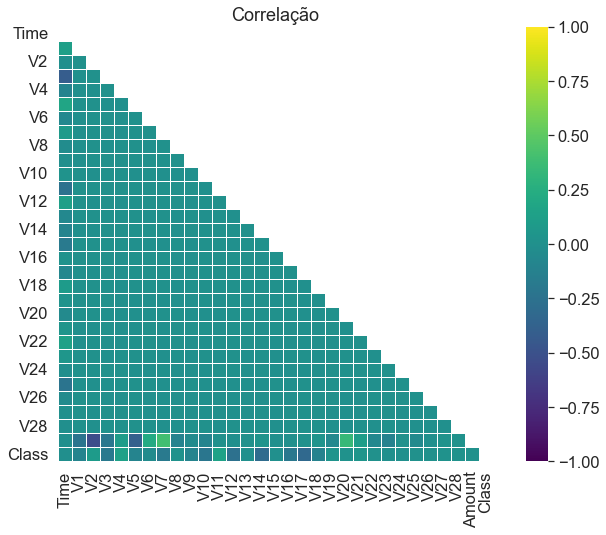

In [17]:
plt.figure(figsize=(12,8))
plt.title('Correlação')

mask = np.zeros_like(df.corr(), dtype=np.bool8)
mask[np.triu_indices_from(mask)]= True


sns.heatmap(df.corr(), mask=mask, square=True, linewidths=0.5, cmap='viridis', vmin=-1, vmax=1, annot_kws={'size': 12})
plt.show()

Podemos notar que não existe uma correlação muito forte entre os dados, apenas uma feature ou outra possui um correlacionamento. Vamos remover os correlacionamentos com valor acima de 50%

In [18]:
CORR = 0.5

In [19]:
corr_matrix = df.drop(columns=['Class', 'Time', 'Data']).corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8))
                  .unstack()
                  .sort_values(ascending=False))
col_corr = list(map(lambda x: x[1], sol[sol.values > CORR].keys()))
print('Colunas com correlação > {} %'.format(CORR), col_corr)

Colunas com correlação > 0.5 % ['V2']


## Modelagem dos dados


Vamos remover a informação de `Time, Class e Data` e as colunas com correlação do dataset pois esses features não serão utilizadas na previsão e vamos precisar padronizar o valor de `Amount` para que não haja diferença de escala com base nos outros valores das demais features

In [20]:
scaler = StandardScaler()
scaler.fit(df['Amount'].values.reshape(-1, 1))

normal['Amount'] = scaler.transform(normal['Amount'].values.reshape(-1,1))
fraude['Amount'] = scaler.transform(fraude['Amount'].values.reshape(-1,1))

In [21]:
dump(scaler, open('./model/std_scaler.sav', 'wb'))

In [22]:
y_normal = normal['Class']
y_fraude = fraude['Class']

In [23]:
normal = normal.drop(columns=['Class', 'Time', 'Data']).drop(columns=col_corr)
fraude = fraude.drop(columns=['Class', 'Time', 'Data']).drop(columns=col_corr)

## Matriz de custo benefício

Vamos criar uma função para validar aqui o quanto de benefício nosso modelo trará ao identificar as fraudes e o custo que teremos caso essas fraudes passem.

### Definição para a validação do custo/benefício

!['Fraude com cartão'](./images/fraude.png)

https://risk.lexisnexis.com/global/pt/about-us/press-room/press-release/20211020-true-cost-of-fraud-latam

Dado que o valor de uma transação seja 1,00 real e que para uma empresa checar se o consumidor realmenente adquiriu um bem ela gaste 10% desse valor e 386% o valor da transação para solucionar a fraude, qual o impacto operacional se um modelo conseguir impedir uma fraude ?

In [24]:
def calcular_custo_beneficio(model, tp, fp, tn, fn, valor_transacao = 1000.0):
    """Exibe uma matriz de custo/benefício"""
 
    receita_operacional = tp * valor_transacao
    fraude_identificada = fp * valor_transacao * 3.86
    
    receita_validada = tn * valor_transacao * .9
    fraude_validada = tn * valor_transacao * .1
    
    receita_fraudada = fn * valor_transacao * 3.86
    
    resultado_final = round((receita_operacional + receita_validada) - (fraude_validada + receita_fraudada), 2)
    
    data = {
        'Total de Transações': tp + tn + fp + fn,
        'Total Transações Válidas': tp + tn,
        'Receita Total': round(receita_operacional + receita_validada,2),
        'Transações Válidas': tp,
        'Receita Transações Validas': round(receita_operacional, 2),
        'Transações Checadas': tn,
        'Receita Transações Checadas': round(receita_validada, 2),
        'Custom com Checagem': round(fraude_validada, 2),
        'Total de Fraudes': fp + fn,
        'Fraudes Não Identificadas': fn,
        'Custo com Fraudes' : round(receita_fraudada, 2),
        'Fraudes Identificadas': fp,
        'Save de Fraudes Identificas': round(fraude_identificada, 2),
        'Resultado Operacional': resultado_final
    }
    
    data = pd.DataFrame.from_dict(data, orient='index').transpose()
    data.index = [model]
    return data

## Base line

Vamos criar um modelo baseline para o nosso modelo principal. O objetivo desse modelo base line e validar como duas estruturas de aprendizados podem chegar a um valor muito próximo um do outro.

Vamos utilizar um classificador do tipo Support Vector Machine para fazer a classificação dos dados. Para isso, vamos obter uma amostra do dataset de registros normais com a mesma quantidade de registros fraudados.

In [25]:
X = normal.sample(len(fraude))
y = y_normal[X.index]

X = pd.concat([X, fraude])
y = np.concatenate((y, y_fraude), axis=None)

Vamos criar as massas de treino e teste e criar o classificador SVM

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
svc = SVC(kernel='linear', random_state=RANDOM_SEED)
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Vamos verificar como foi o treinamento do modelo

In [28]:
print('Score: {}' .format(svc.score(X_train, y_train)))

Score: 0.9415501905972046


Vamos agora avaliar o teste

In [29]:
y_test_pred = svc.predict(X_test)

In [30]:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[97  2]
 [11 87]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        99
           1       0.98      0.89      0.93        98

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197



Vamos validar se o modelo conseguiria identificar os registros de fraude na base desbalanceada

In [31]:
X = pd.concat([normal, fraude])
y = np.concatenate((y_normal, y_fraude), axis=None)

In [32]:
indexs = np.random.permutation(len(X))

X = X.iloc[indexs]
y = y[indexs]

In [33]:
y_pred = svc.predict(X)

In [34]:
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

[[277745   6570]
 [    44    448]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.06      0.91      0.12       492

    accuracy                           0.98    284807
   macro avg       0.53      0.94      0.55    284807
weighted avg       1.00      0.98      0.99    284807



Vamos agora validar o quanto o nosso modelo performance em questão de custo/beneficio

In [35]:
cf_svc = pd.DataFrame(confusion_matrix(y, y_pred), columns=LABELS)
cf_svc.index = LABELS
cf_svc

,Normal,Fraude
Normal,277745,6570
Fraude,44,448


In [36]:
cb_svm = calcular_custo_beneficio('SVM', cf_svc.loc['Normal']['Normal'], cf_svc.loc['Fraude']['Fraude'],
                           cf_svc.loc['Normal']['Fraude'], cf_svc.loc['Fraude']['Normal'])
cb_svm

,Total de Transações,Total Transações Válidas,Receita Total,Transações Válidas,Receita Transações Validas,Transações Checadas,Receita Transações Checadas,Custom com Checagem,Total de Fraudes,Fraudes Não Identificadas,Custo com Fraudes,Fraudes Identificadas,Save de Fraudes Identificas,Resultado Operacional
SVM,284807.0,284315.0,283658000.0,277745.0,277745000.0,6570.0,5913000.0,657000.0,492.0,44.0,169840.0,448.0,1729280.0,282831160.0


## Arquitetura do modelo

Vamos utilizar um modelo baseado em Autoencoders, com aprendizado não-supervisioinado, para aprender as caracteristicas de transações normais e vamos utilizar do processo de reconstrução para identificar os registros com anomalias, uma vez que os registros com `Fraude` terão um erro de reconstrução maior devido ao modelo não "conhecer" essas caracteristicas que o definem como fraudulento.

!['Autoencoder'](./images/autoencoders.png)

Vamos dividir os dados em treino e teste para criar nosso modelo. Como vamos criar um modelo baseado em `autoencoders` e aprender as caracteristicas das transações válidas, vamos filtrar primeiramente apenas os registros com a classe `Normal` e dividi-los em sub-amostragens para treino e teste. Os registros com classe `Fraude` serão utilizadas apenas no processo de teste.

In [37]:
train, test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [38]:
print('Treino: ', train.shape)
print('Test: ', test.shape)

Treino:  (227452, 28)
Test:  (56863, 28)


In [39]:
features = len(train.columns)
print(features)

28


### Definição do modelo

Vamos definir nosso modelo inicialmente criando a camada de encoder e posterior a camanda de decoder.

In [40]:
tf.keras.backend.clear_session()

In [41]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
input_shape = (features,)
print(input_shape)

(28,)


In [43]:
KERNEL = 'random_normal'
ALPHA_LR =  0.3
MOMENTUM_BN = 0.99
DROPOUT = 0.1

In [44]:
encoder = Sequential([
    Dense(24, input_shape=input_shape, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dense(21, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dense(18, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    BatchNormalization(momentum=MOMENTUM_BN),
    Dense(15, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dense(12, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dense(9, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    BatchNormalization(momentum=MOMENTUM_BN),
    Dense(6, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    BatchNormalization(momentum=MOMENTUM_BN),
], name='encoding')

decoder = Sequential([
    Dense(9, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    BatchNormalization(momentum=MOMENTUM_BN),
    Dense(12, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dropout(DROPOUT),
    Dense(15, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    BatchNormalization(momentum=MOMENTUM_BN),
    Dense(18, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dense(21, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    BatchNormalization(momentum=MOMENTUM_BN),
    Dense(24, kernel_initializer=KERNEL),
    LeakyReLU(alpha=ALPHA_LR),
    Dense(train.shape[1], activation='linear', kernel_initializer=KERNEL)
], name='decoding')

In [45]:
model = Sequential([encoder, decoder], name='autoencoder')

In [46]:
model.compile(optimizer = Adam(0.01), loss = 'mse', metrics=['accuracy'])

In [47]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoding (Sequential)       (None, 6)                 2403      
                                                                 
 decoding (Sequential)       (None, 28)                2473      
                                                                 
Total params: 4,876
Trainable params: 4,720
Non-trainable params: 156
_________________________________________________________________


In [48]:
encoder.summary(), decoder.summary()

Model: "encoding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                696       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 21)                525       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 21)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                396       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 18)                0         
                                                                 
 batch_normalization (BatchN  (None, 18)               72 

(None, None)

In [49]:
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, min_lr=0.001, factor=0.01)

In [50]:
cp = ModelCheckpoint('./model/autoencoders.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [51]:
with tf.device('/GPU:0'):
    history = model.fit(train, train, batch_size=256, validation_data=(test, test), epochs=150, callbacks=[cp, rp])

Epoch 1/150
886/889 [============================>.] - ETA: 0s - loss: 0.6388 - accuracy: 0.4775
Epoch 1: val_loss improved from inf to 1.37781, saving model to ./model\autoencoders.h5
889/889 [==============================] - 15s 14ms/step - loss: 0.6390 - accuracy: 0.4776 - val_loss: 1.3778 - val_accuracy: 0.3839 - lr: 0.0100
Epoch 2/150
888/889 [============================>.] - ETA: 0s - loss: 0.5466 - accuracy: 0.5208
Epoch 2: val_loss improved from 1.37781 to 0.54659, saving model to ./model\autoencoders.h5
889/889 [==============================] - 12s 14ms/step - loss: 0.5467 - accuracy: 0.5208 - val_loss: 0.5466 - val_accuracy: 0.4725 - lr: 0.0100
Epoch 3/150
886/889 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.5437
Epoch 3: val_loss improved from 0.54659 to 0.48567, saving model to ./model\autoencoders.h5
889/889 [==============================] - 13s 14ms/step - loss: 0.4853 - accuracy: 0.5437 - val_loss: 0.4857 - val_accuracy: 0.5372 - lr: 0.0100

### Avaliando o treinamento do modelo

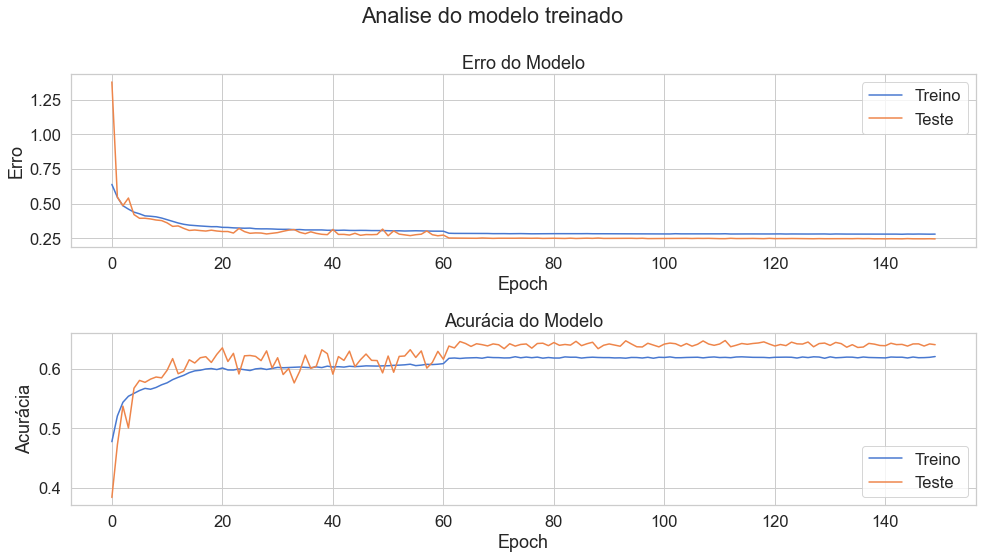

In [52]:
plt.suptitle('Analise do modelo treinado')

plt.subplot(211)
plt.title('Erro do Modelo')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Erro')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'best')

plt.subplot(212)
plt.title('Acurácia do Modelo')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'best')

plt.tight_layout()
plt.show()

### Carregando o modelo treinado

In [53]:
model = tf.keras.models.load_model('./model/autoencoders.h5') 

### Executando o modelo para prever as classes de testes

Vamos inserir agora nos dados de testes os registros de fraude e validar como o modelo conseguirá classificar os registros de fraude

In [54]:
validation = pd.concat([test, fraude])
validation = validation.iloc[np.random.permutation(len(validation))]

In [55]:
validation_pred = model.predict(validation)

Vamos identificar agora o erro da reconstrução gerada pelo modelo. O erro de reconstrução vai ser utilizado para prever a probabilidade de uma amostra ser uma instância fraudada. 

O fato de termos utilizado apenas registros `normais` para o treinamento do modelo do autoencoder é que durante o processo de inferência os registros com fraude perde as caracteristicas da fraude e o decodificador as reconstroi como sendo um registro normal, resultando em um grande erro de reconstrução.

Depois de calcular todos os erros no dataset de teste podemos gerar uma probabilidade, entre 0 e 1, indicando o percentual de anômalia que essa instancia possui. Com base nisso, podemos definir um threshold para limitar quais registros são anômalos.

### Função de calculo de erro para reconstrução

Vamos buscar as labels para os registros de teste

In [56]:
labels = df.iloc[validation.index]['Class'].values

Vamos utilizar o erro quadrático médio para achar o erro de reconstrução do modelo.

$$\textstyle L(x,x') = ||\, x - x'||^2$$

In [57]:
labels_pred = np.mean(np.power(validation-validation_pred, 2), axis=1)

In [58]:
labels_pred = np.array(labels_pred).reshape(-1,1)

In [59]:
labels_pred[0:5]

array([[0.07746515],
       [0.20066743],
       [0.89615659],
       [0.51430966],
       [0.03859605]])

Vamos normalizar os erros para eles ficarem em uma mesma escala

In [60]:
error_scaler = MinMaxScaler()
error_scaler.fit(labels_pred)

MinMaxScaler()

In [61]:
dump(error_scaler, open('./model/error_scaler.sav', 'wb'))

In [62]:
previsao_fraude = error_scaler.transform(labels_pred).flatten()

In [63]:
previsao_fraude[0:5]

array([0.00047967, 0.00137686, 0.00644157, 0.00366087, 0.00019662])

In [64]:
true_labels = [i for i, label in enumerate(labels) if label == 1]

print(labels[true_labels[0:5]])
print(previsao_fraude[true_labels[0:5]])

[1 1 1 1 1]
[0.09887974 0.27136374 0.06531458 0.16198614 0.03785324]


Vamos verificar agora se o modelo foi capaz de identificar as anomalias nas transações.

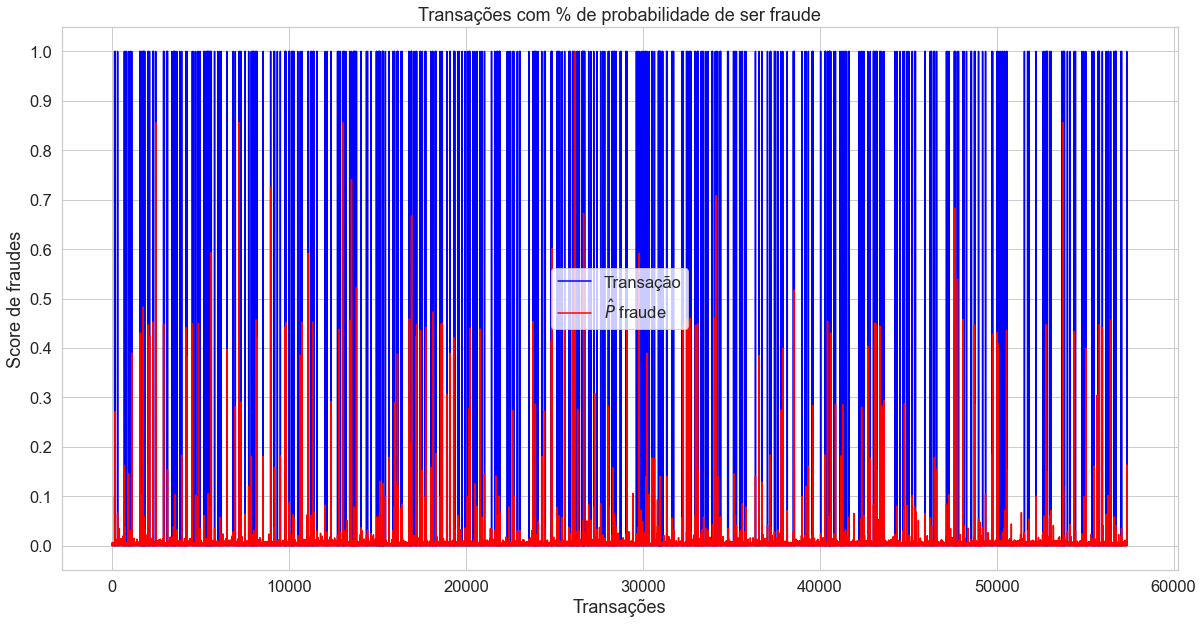

In [65]:
plt.figure(figsize=(20,10))
plt.title('Transações com % de probabilidade de ser fraude')
plt.plot(labels, c='blue', label='Transação')
plt.plot(previsao_fraude, c='red', label='$\hat{P}$ fraude')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Transações')
plt.ylabel('Score de fraudes')
plt.legend()
plt.show()

## Avaliação do modelo

Vamos avaliar agora se o nosso modelo teve uma boa taxa de acerto nos dados de testes. Vamos utilizar a curva ROC-AUC para medir a eficácia de nosso modelo em distingir as duas classes. 

Valores perto do canto superior esquerdo, perto de 1, indicam que o classificar é bom em distinguir as classes e valores abaixo da área média, perto de 0.5, indicam que o modelo não conseguiu distinguir entre as classes.

In [66]:
fpr, tpr, threshold = roc_curve(labels, previsao_fraude)

In [67]:
score_auc = roc_auc_score(labels, previsao_fraude)
print('Score AUC: ', score_auc)

Score AUC:  0.9462871036919573


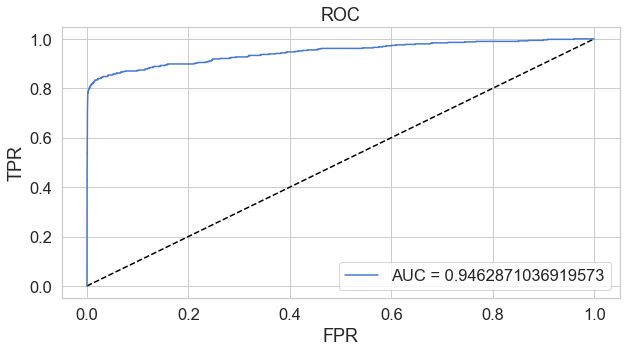

In [68]:
plt.figure(figsize = (10,5))
plt.title('ROC')
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr, tpr, label = 'AUC = {}'.format(score_auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Nosso modelo conseguiu classificar bem os eventos com transações com as duas labels. Porém como temos dados desbalanceados o ROC pode não expressar corretamente o quao bom ou ruim esta nosso modelo. Vamos utilizar para isso outras métricas de avaliação.

## Precisão vs Recal

!['Precisao vs Recall'](./images/precision_recall.png)

Precisão e Recall são métricas para avaliar o quanto um modelo esta conseguindo identificar as classes corretas durante um processo de classificação. Porém a precisão e o recall tem objetivos distintos na identificação do quão bem o modelo esta classificando.

Precisão e recall são definidos da seguinte forma:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

* A precisão mede a relevância dos resultados obtidos. 

* Recall, por outro lado, mede quantos resultados relevantes são retornados.

Ambos os valores podem ter valores entre 0 e 1.

Vamos calcular agora os valores e plotar em um gráfico

In [69]:
precision, recall, th = precision_recall_curve(labels, previsao_fraude)

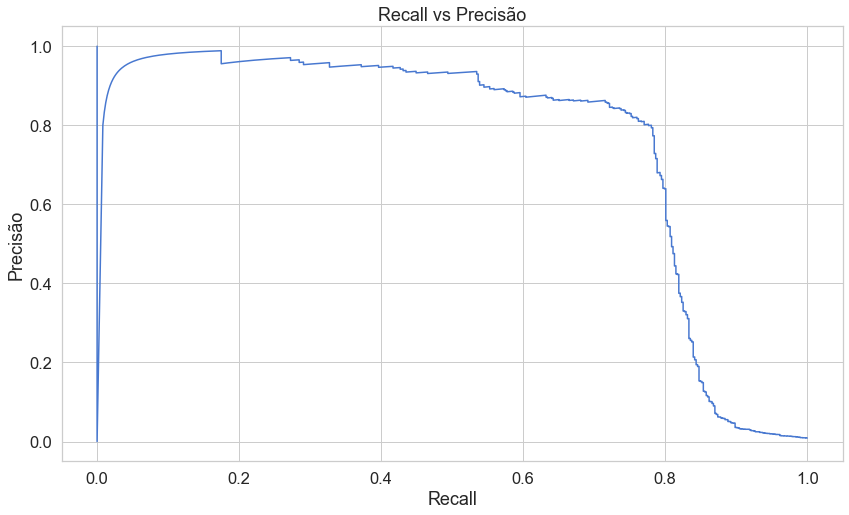

In [70]:
plt.title('Recall vs Precisão')
plt.plot(recall, precision, 'b', label = 'Curva Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

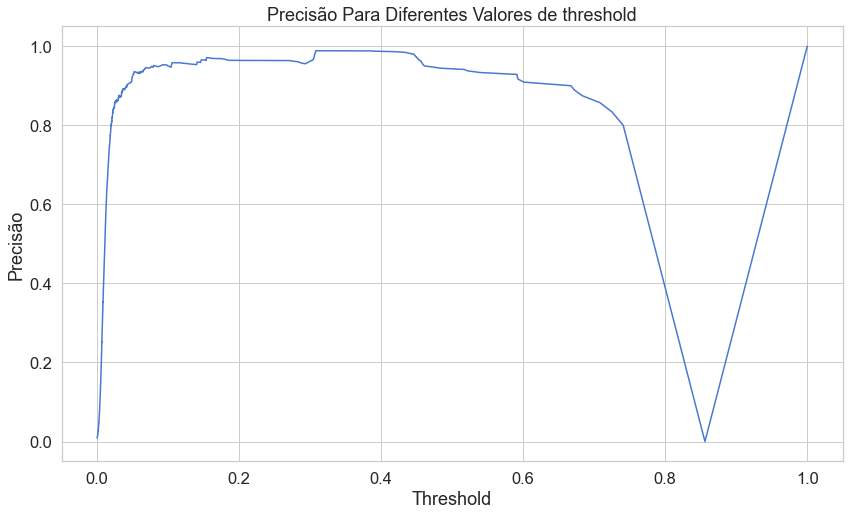

In [71]:
plt.plot(th, precision[1:], 'b', label = 'Curva Threshold-Precisão')
plt.title('Precisão Para Diferentes Valores de threshold')
plt.xlabel('Threshold')
plt.ylabel('Precisão')
plt.show()

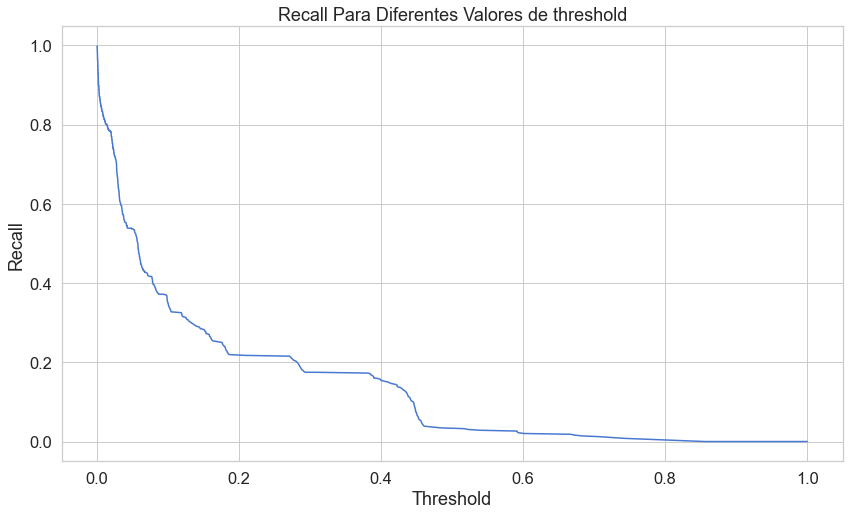

In [72]:
plt.plot(th, recall[1:], 'b', label = 'Curva Threshold-Recall')
plt.title('Recall Para Diferentes Valores de threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

## Identificando fraudes

Precisamos agora definir um limite de threshold para o nosso modelo. Valores acima desse limite indicaram que os registros possuem fraude na transação, então precisamos achar um valor que consiga identificar o maior número possível de fraudes.

Vamos utilizar como base a métrica de F1-Score, que é uma média harmônica de precisão e recall.

In [73]:
limites_fraude = [(previsao_fraude > i).astype(np.int32) for i in threshold]
f1_scores = [f1_score(labels, i) for i in limites_fraude]

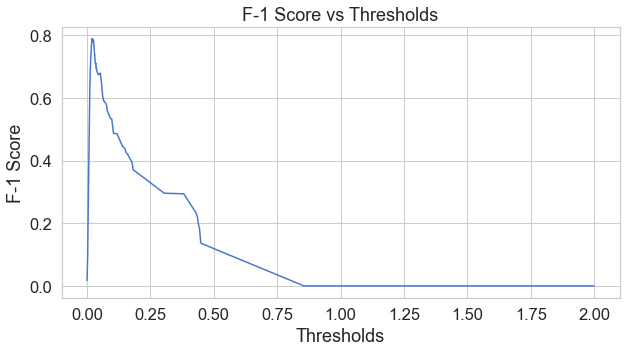

In [74]:
plt.figure(figsize = (10, 5))
plt.title('F-1 Score vs Thresholds')
plt.plot(threshold, f1_scores)
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.show()

Vamos obter o melhor threshold

In [75]:
print(np.min(f1_scores))
print(np.max(f1_scores))

0.0
0.7888774459320288


In [76]:
threshold

array([2.00000000e+00, 1.00000000e+00, 8.55970117e-01, ...,
       1.06191632e-04, 1.06053642e-04, 0.00000000e+00])

In [77]:
melhor_threshold = threshold[f1_scores.index(np.max(f1_scores))]
print('Melhor Threshold = {}'.format(melhor_threshold))

Melhor Threshold = 0.020029744663351008


Vamos agora classificar nossos registros com base nesse threshold

In [144]:
ajuste = 0.0102

In [145]:
indicador_fraude = (previsao_fraude > (melhor_threshold - ajuste)).astype(np.int32)

In [146]:
indicador_fraude

array([0, 0, 0, ..., 0, 0, 0])

Vamos analisar agora como ficou as classificações dos registros com base no threshold selecionado

In [147]:
cf_model = pd.DataFrame(confusion_matrix(labels, indicador_fraude), columns=LABELS)
cf_model.index = LABELS
print(cf_model)

        Normal  Fraude
Normal   56332     531
Fraude      91     401


In [148]:
indicador_fraude_final = ['normal' if i == 0 else 'fraude' for i in indicador_fraude]

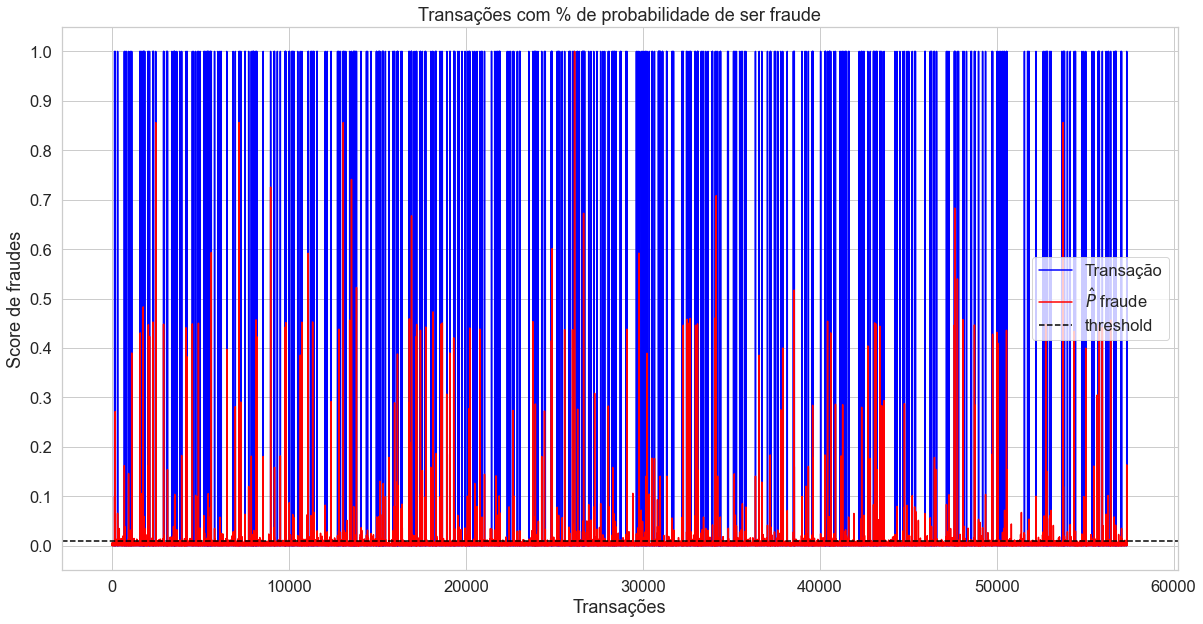

In [149]:
plt.figure(figsize=(20,10))
plt.title('Transações com % de probabilidade de ser fraude')
plt.plot(labels, c='blue', label='Transação')
plt.plot(previsao_fraude, c='red', label='$\hat{P}$ fraude')

plt.axhline(y = (melhor_threshold - ajuste), linestyle = '--', label = 'threshold', color='black')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Transações')
plt.ylabel('Score de fraudes')
plt.legend()
plt.show()

## Metricas de performance

In [150]:
precision = precision_score(labels, indicador_fraude)
recall = recall_score(labels, indicador_fraude)
f1_sc = f1_score(labels, indicador_fraude)
accuracy_sc = accuracy_score(labels, indicador_fraude)

In [151]:
print("""Métricas de Avaliação do Modelo:
         Precision = {}
         Recall = {}
         Score F1 = {}
         Acurácia = {}"""
      .format(precision, recall, f1_sc, accuracy_sc))

Métricas de Avaliação do Modelo:
         Precision = 0.4302575107296137
         Recall = 0.8150406504065041
         Score F1 = 0.5632022471910112
         Acurácia = 0.9891552610931915


In [152]:
print(classification_report(labels, indicador_fraude))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.43      0.82      0.56       492

    accuracy                           0.99     57355
   macro avg       0.71      0.90      0.78     57355
weighted avg       0.99      0.99      0.99     57355



Vamos validar agora todo o dataset para ter uma análise comparativa de quanto o modelo conseguirá identificar e qual será o custo/benefício

In [153]:
validation_all = pd.concat([fraude, normal])
validation_all = validation_all.iloc[np.random.permutation(len(validation_all))]

In [154]:
validation_pred_all = model.predict(validation_all)

In [155]:
labels_all = df.iloc[validation_all.index]['Class'].values

In [156]:
labels_pred_all = np.mean(np.power(validation_all-validation_pred_all, 2), axis=1)

In [157]:
labels_pred_all = np.array(labels_pred_all).reshape(-1,1)

In [158]:
previsao_fraude_all = error_scaler.transform(labels_pred_all).flatten()

In [159]:
indicador_fraude_all = (previsao_fraude_all > (melhor_threshold - ajuste)).astype(np.int32)

In [160]:
cf_model_all = pd.DataFrame(confusion_matrix(labels_all, indicador_fraude_all), columns=LABELS)
cf_model_all.index = LABELS
print(cf_model_all)

        Normal  Fraude
Normal  281702    2613
Fraude      91     401


In [161]:
cb_ae = calcular_custo_beneficio('AE', cf_model_all.loc['Normal']['Normal'], cf_model_all.loc['Fraude']['Fraude'],
                        cf_model_all.loc['Normal']['Fraude'], cf_model_all.loc['Fraude']['Normal'])

cb_ae

,Total de Transações,Total Transações Válidas,Receita Total,Transações Válidas,Receita Transações Validas,Transações Checadas,Receita Transações Checadas,Custom com Checagem,Total de Fraudes,Fraudes Não Identificadas,Custo com Fraudes,Fraudes Identificadas,Save de Fraudes Identificas,Resultado Operacional
AE,284807.0,284315.0,284053700.0,281702.0,281702000.0,2613.0,2351700.0,261300.0,492.0,91.0,351260.0,401.0,1547860.0,283441140.0


## Comparando matrizes
<!-- 
Total de transações: 284807
--------------------
284315 Transações válidas
= Receita total: 283762200.00
+ 278787 Transações válidas: 278787000.00
+ 5528 Transações checadas: 4975200.00
- Custom com checagem: 552800.00
--------------------
492 Fraudes
- 44 Custo 169840.00
+ 448 Fraude identificada (save): 1729280.00

Resultado final: 283039560.0


| Modelo |Total de trans.| Trans. válidas|Receita Total Trans.|Total Trans. Valida|Receita Trans. Valida|Total Trans. Checadas|Receita Trans. Checadas|Custo checagem|Total de fraudes|Fraude Ident.|Fraude Evitada|Fraude não evitada| Custo Fraude| Receita Final|
|--------|---------------|---------------|--------------------|-------------------|---------------------|---------------------|-----------------------|--------------|----------------|-------------|--------------|-|-|-|
| SVC    |284.807        | 284.315       | 283.762.200,00     | 278.787           |   278.787.000,00    |  5.528              |  4.975.200,00         |  552.800,00  |     492        |  448        | 1.729.280,00 |44|169.840,00|283.039.560,00|
| AE     |284.807        | 284.315       | 284.191.900,00     | 283.084           |   283.084.000,00    |  1231               |  1.107.900,00         |  123.100,00  |     492        |  380         | 1.466.800,00 |112|432.320,00|283.636.480,00| -->

In [162]:
pd.concat([cb_svm, cb_ae])

,Total de Transações,Total Transações Válidas,Receita Total,Transações Válidas,Receita Transações Validas,Transações Checadas,Receita Transações Checadas,Custom com Checagem,Total de Fraudes,Fraudes Não Identificadas,Custo com Fraudes,Fraudes Identificadas,Save de Fraudes Identificas,Resultado Operacional
SVM,284807.0,284315.0,283658000.0,277745.0,277745000.0,6570.0,5913000.0,657000.0,492.0,44.0,169840.0,448.0,1729280.0,282831160.0
AE,284807.0,284315.0,284053700.0,281702.0,281702000.0,2613.0,2351700.0,261300.0,492.0,91.0,351260.0,401.0,1547860.0,283441140.0


## Conclusão

Analisando os resultados gerados pelas matrizes de confusão e posteriormente pela matriz de custo benefício podemos perceber que o modelo base com SVM conseguiu ter uma taxa de Verdadeiros Negativo muito maior, conseguindo assim identificar um maior número de fraudes - impedindo que uma transação passe e cause um prejuizo à uma companhia. No entanto O SVM teve uma alta taxa de erros do tipo I, onde classificou erroneamente transações válidas como fraude, ocasionando uma perda percentual da transação com checagem. 

Por outro lado o modelo de Autoencoders conseguiu ter um desempenho muito significativo tendo uma taxa muito de Erro I muito abaixo do modelo de SVM, cerca de 2.5x menor, no entanto o Erro do tipo II foi bem maior que o modelo de SVM, aproximadamente de 2x maior. 

Avaliando ambos os modelos e aplicando um cenário hipotético o modelo de Autoencoders teve um resultado melhor, mesmo identificando menos fraudes que o SVM, no resultado operacional tendo uma margem liquida no valor de 609.980 de receita.
Concluindo, ambos os modelos apresentaram um ganho significativo quando se aplica um algoritmo para esse tipo de operação - Identificação de Fraudes em transações financeiras - e podemos observar que com abordagens diferentes chegamos a um resultado muito próximo mostrando assim que para se resolver um problema podemos seguir por diferentes abordagens e conseguir resultados muito satisfatórios.